In [1]:
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def monthly_to_annual(array):
    """ calculate annual mena from monthly data, using unequal month lengths fros noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [3]:
datadir = '/glade/scratch/charlie/archive/cesm_edriven_idealizedcdr_feb2022_v3'

lnd_in = xr.open_dataset(datadir+'/lnd/hist/cesm_edriven_idealizedcdr_feb2022_v3.clm2.sofar.nc')
ocn_in = xr.open_dataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.sofar.nc', decode_times=False)
atm_in = xr.open_dataset(datadir+'/atm/hist/cesm_edriven_idealizedcdr_feb2022_v3.cam.sofar.nc')

areacella = xr.open_dataset('/glade/scratch/charlie/cmip/areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areacello = xr.open_dataset('/glade/scratch/charlie/cmip/areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc')

sftlf = xr.open_dataset('/glade/scratch/charlie/cmip/sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftgif = xr.open_dataset('/glade/scratch/charlie/cmip/sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')



/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding 

In [4]:
nyears = len(lnd_in['time'])/12.
print(nyears)

150.0


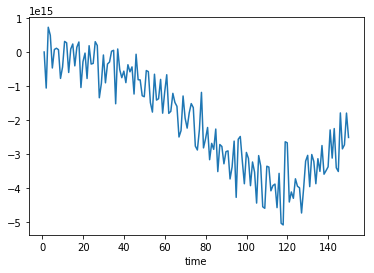

In [5]:
nbp_global = (lnd_in['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global['time'] = np.arange(len(nbp_global['time']))/12.
nbp_annual = (monthly_to_annual(nbp_global)*86400. * 365.)
#nbp_annual.cumsum().plot()
nbp_annual.plot()

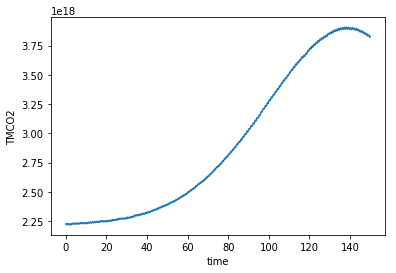

In [6]:
atmco2burden = (atm_in['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1e3
atmco2burden['time'] = np.arange(len(atmco2burden['time']))/12.
atmco2burden.plot()

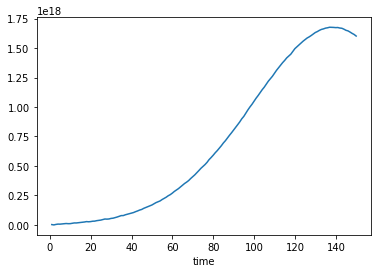

In [7]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

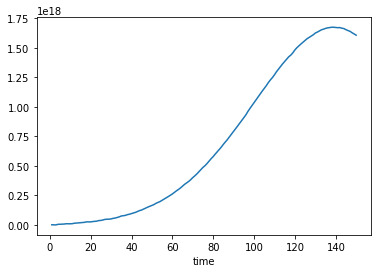

In [8]:
annual_atm_accum = monthly_to_annual(atmco2burden- atmco2burden[0])
annual_atm_accum.plot()

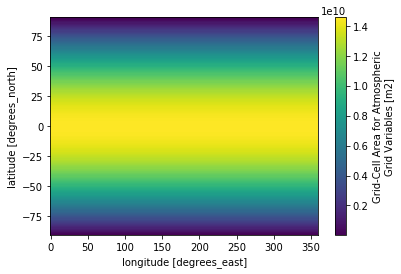

In [9]:
areacella['areacella'].plot()

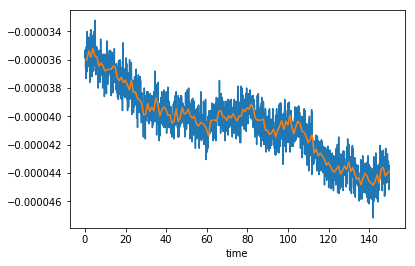

In [10]:
ssh_global = (ocn_in['SSH'] * areacello['areacello'].data).sum(dim=('nlat', 'nlon')) / (areacello['areacello']).sum(dim=('nlat', 'nlon'))
ssh_global['time'] = np.arange(len(ssh_global['time']))/12.
ssh_global_annual = monthly_to_annual(ssh_global)
ssh_global.plot()
ssh_global_annual.plot()


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


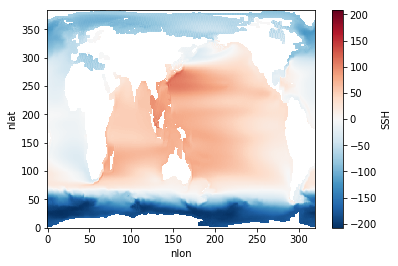

In [11]:
ocn_in['SSH'].mean(dim='time').plot()

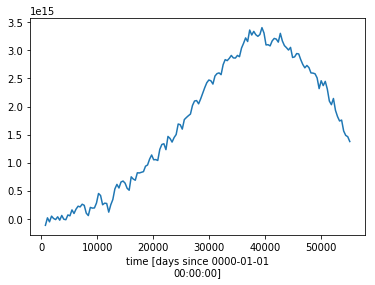

In [12]:
fgco2_global = (ocn_in['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual = monthly_to_annual(fgco2_global)
fgco2_global_annual.plot()


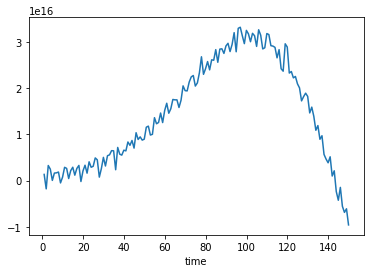

In [13]:
(fgco2_global_annual.data - nbp_annual.data + sfco2_annual).plot()

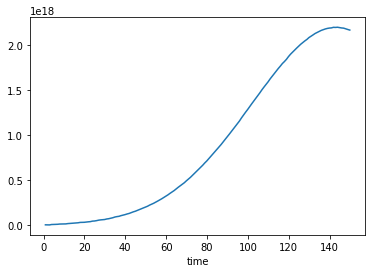

In [14]:
(fgco2_global_annual.cumsum().data - nbp_annual.cumsum().data + annual_atm_accum).plot()

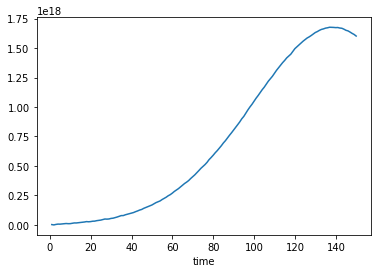

In [15]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

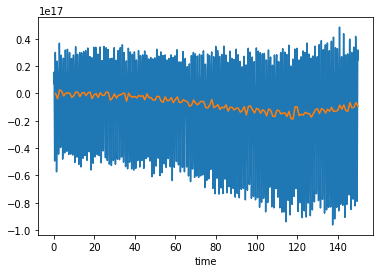

In [16]:
sfco2_lnd = (atm_in['SFCO2_LND'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_lnd['time'] = np.arange(len(sfco2_lnd['time']))/12.
sfco2_lnd_annual = monthly_to_annual(sfco2_lnd) 
sfco2_lnd.plot()
sfco2_lnd_annual.plot()

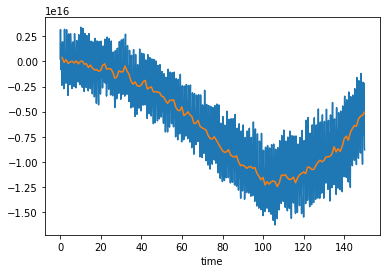

In [17]:
sfco2_ocn = (atm_in['SFCO2_OCN'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_ocn['time'] = np.arange(len(sfco2_ocn['time']))/12.
sfco2_ocn_annual = monthly_to_annual(sfco2_ocn) 
sfco2_ocn.plot()
sfco2_ocn_annual.plot()

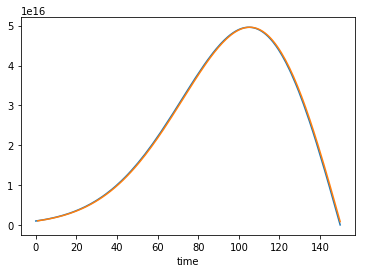

In [18]:
sfco2_fff = (atm_in['SFCO2_FFF'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_fff['time'] = np.arange(len(sfco2_fff['time']))/12.
sfco2_fff_annual = monthly_to_annual(sfco2_fff) 
sfco2_fff.plot()
sfco2_fff_annual.plot()

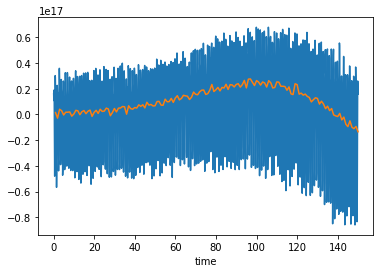

In [19]:
sfco2_tot = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_tot['time'] = np.arange(len(sfco2_tot['time']))/12.
sfco2_tot_annual = monthly_to_annual(sfco2_tot) 
sfco2_tot.plot()
sfco2_tot_annual.plot()

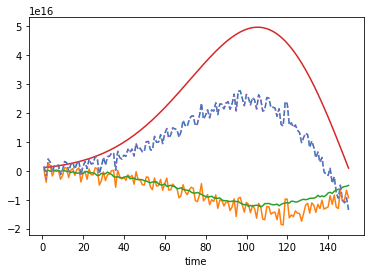

In [20]:
sfco2_tot_annual.plot(linestyle='--')
sfco2_lnd_annual.plot()
sfco2_ocn_annual.plot()
sfco2_fff_annual.plot()
(sfco2_lnd_annual + sfco2_ocn_annual + sfco2_fff_annual).plot(linestyle='dotted')

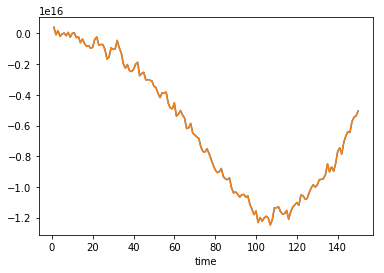

In [21]:
fgco2_global_annual['time'] = np.arange(len(fgco2_global_annual['time']))+1.
(0.-fgco2_global_annual * 44./12.).plot()
sfco2_ocn_annual.plot()

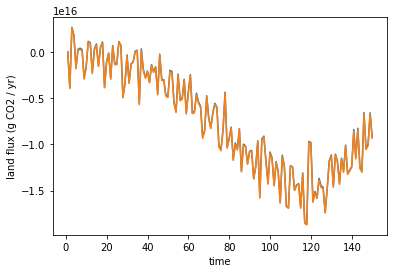

In [22]:
(nbp_annual*44./12.).plot()
sfco2_lnd_annual.attrs['long_name'] = 'land flux (g CO2 / yr)'
sfco2_lnd_annual.plot()


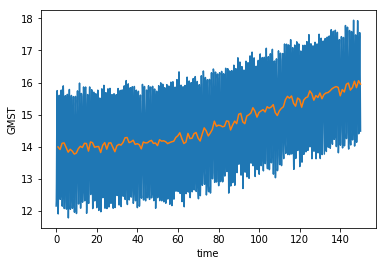

In [23]:
gmst =  -273.15 +(atm_in['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst['time'] = np.arange(len(gmst['time']))/12.
gmst_annual = monthly_to_annual(gmst)
gmst_annual.attrs['long_name'] = 'GMST'
gmst.attrs['long_name'] = 'GMST'
gmst.plot()
gmst_annual.plot()

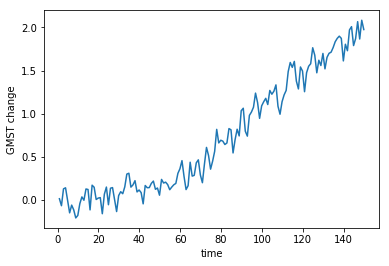

In [24]:
annual_gmst_difference = (gmst_annual - gmst_annual[0:20].mean(dim='time'))
annual_gmst_difference.attrs['long_name'] = 'GMST change'
annual_gmst_difference.plot()

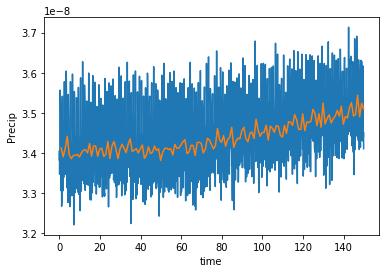

In [25]:
precip =  ((atm_in['PRECC'] + atm_in['PRECL']) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
precip['time'] = np.arange(len(precip['time']))/12.
precip_annual = monthly_to_annual(precip)
precip_annual.attrs['long_name'] = 'Precip'
precip.attrs['long_name'] = 'Precip'
precip.plot()
precip_annual.plot()

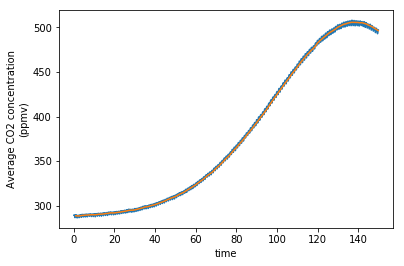

In [26]:
lnd_co2_ppmv = (lnd_in['PCO2']/lnd_in['PBOT']).mean(dim=('lat', 'lon')) * 1e6
lnd_co2_ppmv['time'] = np.arange(len(lnd_co2_ppmv['time']))/12.
lnd_co2_ppmv_annual = monthly_to_annual(lnd_co2_ppmv)
lnd_co2_ppmv.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv_annual.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv.plot()
lnd_co2_ppmv_annual.plot()

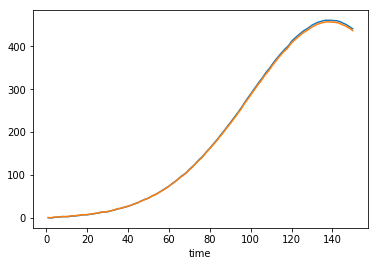

In [27]:
ppm_to_pgc = 2.124

atm_co2_pgc = ppm_to_pgc *(lnd_co2_ppmv_annual - lnd_co2_ppmv_annual[0])

atm_co2_pgc.plot()

((1e-15 * 12./44.)*sfco2_tot_annual).cumsum().plot()

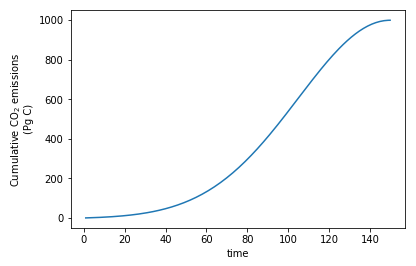

In [28]:
cumulative_emissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual).cumsum()
cumulative_emissions_pgc.attrs['long_name'] = 'Cumulative CO$_2$ emissions (Pg C)'
cumulative_emissions_pgc.plot()

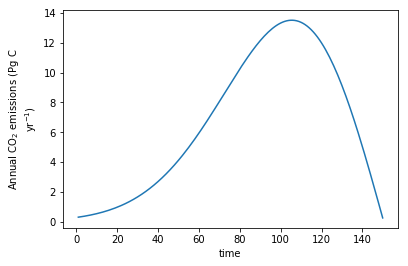

In [29]:
annual_emmissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual)
annual_emmissions_pgc.attrs['long_name'] = 'Annual CO$_2$ emissions (Pg C yr$^{-1}$)'
annual_emmissions_pgc.plot()

TCRE =  1.9807253107252967


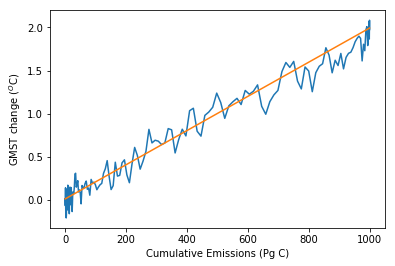

In [30]:
plt.plot(cumulative_emissions_pgc, annual_gmst_difference)


m, b = np.polyfit(cumulative_emissions_pgc[0:110], annual_gmst_difference[0:110], 1)
plt.plot(cumulative_emissions_pgc, m*cumulative_emissions_pgc + b)


plt.ylabel('GMST change ($^O$C)')
plt.xlabel('Cumulative Emissions (Pg C)')

print('TCRE = ', m * 1000.)


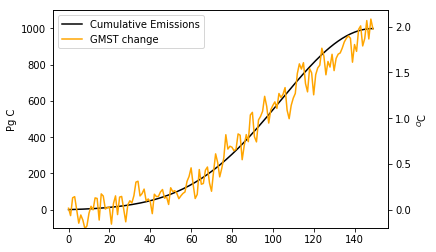

In [31]:
ax1 = plt.subplot()
l1, = ax1.plot(cumulative_emissions_pgc, color='black')
ax2 = ax1.twinx()
l2, = ax2.plot(annual_gmst_difference, color='orange')

ax1.set_ylim((-100,1100))
ax1.set_ylabel('Pg C')

ax2.set_ylim((-100. * m, 1100. * m))
ax2.set_ylabel('$^O$C')

plt.legend([l1, l2], ["Cumulative Emissions", "GMST change"])

plt.show()

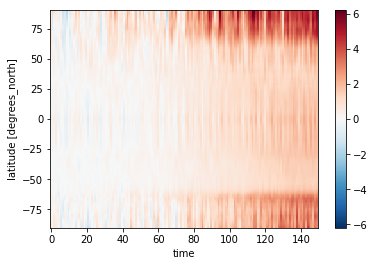

In [32]:
zonal_mean_temp = monthly_to_annual(atm_in['TREFHT'] - 273.15).mean(dim='lon')
zonal_mean_temp['time'] = np.arange(len(zonal_mean_temp['time']))
zonal_mean_temp_diff = zonal_mean_temp - zonal_mean_temp.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_temp_diff.plot(x='time',y='lat')

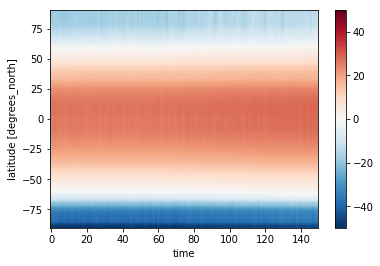

In [33]:
zonal_mean_temp.plot(x='time',y='lat')

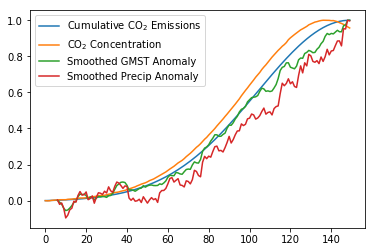

In [35]:
plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions')
plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration')
plt.plot(annual_gmst_difference.rolling(time=7).mean()/annual_gmst_difference.rolling(time=7).mean().max(), label='Smoothed GMST Anomaly')
plt.plot((precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')).rolling(time=7).mean()/(precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')).rolling(time=7).mean().max(), label='Smoothed Precip Anomaly')
plt.legend()

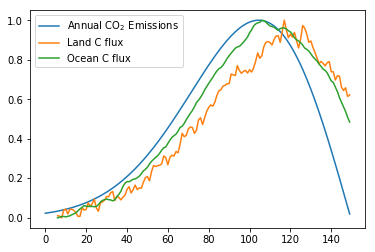

In [36]:
plt.plot(annual_emmissions_pgc/annual_emmissions_pgc.max(), label='Annual CO$_2$ Emissions')
plt.plot((-1. * sfco2_lnd_annual).rolling(time=7).mean()/(-1. * sfco2_lnd_annual).rolling(time=7).mean().max(), label = 'Land C flux')
plt.plot((-1. * sfco2_ocn_annual).rolling(time=7).mean()/(-1. * sfco2_ocn_annual).rolling(time=7).mean().max(), label = 'Ocean C flux')
plt.legend()

In [ ]:
atm_in